In [ ]:
import requests
import pandas as pd
import json

# Function to recursively normalize nested columns in a DataFrame
def recursively_normalize(data):
    df = pd.json_normalize(data)
    while True:
        nested_cols = [col for col in df.columns if isinstance(df[col].iloc[0], (dict, list))]
        if not nested_cols:
            break
        for col in nested_cols:
            if isinstance(df[col].iloc[0], dict):
                normalized = pd.json_normalize(df[col])
                df = df.drop(columns=[col]).join(normalized)
            elif isinstance(df[col].iloc[0], list):
                df = df.explode(col)
                normalized = pd.json_normalize(df[col])
                df = df.drop(columns=[col]).join(normalized)
    return df

# Function to fetch the next batch using the cursor
def fetch_next_batch(cursor):
    response = requests.post(
        f"{base_url}/_sql?format=json",
        headers={"Content-Type": "application/json"},
        json={"cursor": cursor}
    ).json()
    return response

# Elasticsearch base URL
base_url = "http://192.168.20.106:9200"
# Index name
index = "winlogbeat-*"

from datetime import datetime, timedelta

# Calculate the current time and the time one hour ago
current_time = datetime.utcnow()
one_hour_ago = current_time - timedelta(hours=1)

# Format times in ISO8601 format as expected by Elasticsearch
current_time_iso = current_time.strftime('%Y-%m-%dT%H:%M:%SZ')
one_hour_ago_iso = one_hour_ago.strftime('%Y-%m-%dT%H:%M:%SZ')

# SQL query with time filter
sql_query = f"""
SELECT "@timestamp", host.hostname, host.ip, log.level, winlog.event_id, winlog.task, message
FROM "winlogbeat-7.10.0-2024.06.23-*"
WHERE host.hostname = 'win10'
AND winlog.provider_name = 'Microsoft-Windows-Sysmon'
AND "@timestamp" >= '{one_hour_ago_iso}'
AND "@timestamp" <= '{current_time_iso}'
"""

# Initial search request to start scrolling
initial_response = requests.post(
    f"{base_url}/_sql?format=json",
    headers={"Content-Type": "application/json"},
    json={
        "query": sql_query,
        "field_multi_value_leniency": True
    }
).json()

# Extract the cursor for scrolling
cursor = initial_response.get('cursor')
rows = initial_response.get('rows')
columns = [col['name'] for col in initial_response['columns']]

# Initialize CSV file (assumes the first batch is not empty)
if rows:
    df = pd.DataFrame(rows, columns=columns)
    df = recursively_normalize(df.to_dict(orient='records'))
    df.to_csv("lab_logs_blindtest_activity.csv", mode='w', index=False, header=True)

# Track total documents retrieved
total_documents_retrieved = len(rows)
print(f"Retrieved {total_documents_retrieved} documents.")

# Loop to fetch subsequent batches of documents until no more documents are left
while cursor:
    # Fetch next batch of documents using cursor
    response = fetch_next_batch(cursor)
    
    # Update cursor for the next batch
    cursor = response.get('cursor')
    rows = response.get('rows')
    
    # If no rows, break out of the loop
    if not rows:
        break
    
    # Normalize data and append to CSV
    df = pd.DataFrame(rows, columns=columns)
    df = recursively_normalize(df.to_dict(orient='records'))
    
    # Append to CSV file without headers
    df.to_csv("lab_logs_blindtest_activity.csv", mode='a', index=False, header=False)
    
    # Convert DataFrame to JSON, line by line
    json_lines = df.to_json(orient='records', lines=True).splitlines()
    # Append each line to an existing JSON file
    with open("lab_logs_blindtest_activity.json", 'a') as file:
        for line in json_lines:
            file.write(line + '\n')  # Append each line and add a newline
        
    # Update total documents retrieved
    total_documents_retrieved += len(rows)
    
    print(f"Retrieved {total_documents_retrieved} documents.")

print("Files have been written.")


In [2]:
import polars as pl

# Define the path to your CSV file
csv_file_path = 'lab_logs_blindtest_activity.csv'

# Load the CSV file into a DataFrame
df = pl.read_csv(csv_file_path)

# Show the DataFrame to confirm it's loaded correctly
print(df)


shape: (1_027, 7)
┌──────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┐
│ @timestamp   ┆ host.hostna ┆ host.ip     ┆ log.level   ┆ winlog.even ┆ winlog.task ┆ message     │
│ ---          ┆ me          ┆ ---         ┆ ---         ┆ t_id        ┆ ---         ┆ ---         │
│ str          ┆ ---         ┆ str         ┆ str         ┆ ---         ┆ str         ┆ str         │
│              ┆ str         ┆             ┆             ┆ i64         ┆             ┆             │
╞══════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ 2024-06-23T0 ┆ win10       ┆ fe80::965b: ┆ information ┆ 10          ┆ Process     ┆ Process     │
│ 7:42:03.814Z ┆             ┆ 5bf2:7f22:d ┆             ┆             ┆ accessed    ┆ accessed:   │
│              ┆             ┆ 30          ┆             ┆             ┆ (rule:      ┆ RuleName: - │
│              ┆             ┆             ┆             ┆             ┆ 

In [3]:
import polars as pl

def remove_keyword_lines(batch, keywords):
    def modify_line(line):
        # Check each keyword; filter the line if the keyword is at the start followed by a colon
        for keyword in keywords:
            if line.startswith(f"{keyword}:"):
                # Special handling for 'User' keyword
                if keyword == 'User':
                    parts = line.split('\\')
                    if len(parts) > 1:
                        return f"User: {parts[1]}"  # Only keep the part after the backslash
                elif keyword == 'SourceHostname':
                    parts = line.split('.')
                    if len(parts) > 0:
                        return f"{keyword}: {parts[0].split(': ')[1]}"  # Only keep the part before the first dot, remove keyword duplication
                return None  # For other keywords, remove the line altogether
        return line  # Return the line unchanged if no keyword conditions are met

    # Use map_elements to apply a function to each message in the batch
    return batch.map_elements(lambda message: '\n'.join(
        filter(None, (modify_line(line) for line in message.split('\n')))), 
        return_dtype=pl.Utf8)




# Define a list of keywords to filter out
keywords_to_filter = ["UtcTime", "SourceProcessGUID","ProcessGuid", "TargetProcessGUID", "TargetObject", "FileVersion", "Hashes", "LogonGuid", "LogonId", "CreationUtcTime", "User", "ParentProcessGuid", "SourceHostname"]


# Load your DataFrame (assuming 'df' is already loaded)
# Apply the transformation to the 'message' column using map_batches
df_f = df.with_columns(
    pl.col("message").map_batches(lambda batch: remove_keyword_lines(batch, keywords_to_filter), return_dtype=pl.Utf8).alias("filtered_message")
)

# Assuming df_f is your DataFrame with the 'filtered_message' column
# Fetch the first three rows from the 'filtered_message' column
first_messages = df_f["filtered_message"].head(200)

# Print each message completely
for i, message in enumerate(first_messages):
    print(f"Message {i+1}:")
    print(message)
    print("-" * 50)  # Separator for readability


Message 1:
Process accessed:
RuleName: -
SourceProcessId: 1072
SourceThreadId: 1132
SourceImage: C:\Windows\system32\svchost.exe
TargetProcessId: 872
TargetImage: C:\Windows\system32\lsass.exe
GrantedAccess: 0x1000
CallTrace: C:\Windows\SYSTEM32\ntdll.dll+9d584|C:\Windows\System32\KERNELBASE.dll+69f06|c:\windows\system32\lsm.dll+e7f8|c:\windows\system32\lsm.dll+11918|C:\Windows\System32\RPCRT4.dll+799e3|C:\Windows\System32\RPCRT4.dll+dd77b|C:\Windows\System32\RPCRT4.dll+5ce8c|C:\Windows\System32\RPCRT4.dll+59ee8|C:\Windows\System32\RPCRT4.dll+39fa6|C:\Windows\System32\RPCRT4.dll+398f8|C:\Windows\System32\RPCRT4.dll+4766f|C:\Windows\System32\RPCRT4.dll+46a78|C:\Windows\System32\RPCRT4.dll+46061|C:\Windows\System32\RPCRT4.dll+45ace|C:\Windows\System32\RPCRT4.dll+4a1a2|C:\Windows\SYSTEM32\ntdll.dll+20330|C:\Windows\SYSTEM32\ntdll.dll+52f76|C:\Windows\System32\KERNEL32.DLL+17614|C:\Windows\SYSTEM32\ntdll.dll+526a1
--------------------------------------------------
Message 2:
Process access

In [5]:
# Assuming df_f is your modified DataFrame with all necessary columns including 'filtered_message'
# Select specific columns from the DataFrame
selected_columns_df = df_f.select(["log.level", "winlog.event_id", "winlog.task","filtered_message"])

# Write the selected columns to a CSV file
selected_columns_df.write_csv('lab_logs_blindtest_activity_filtered.csv')


In [6]:
selected_columns_df.head(5)

log.level,winlog.event_id,winlog.task,filtered_message
str,i64,str,str
"""information""",10,"""Process accessed (rule: Proces…","""Process accessed: RuleName: - …"
"""information""",10,"""Process accessed (rule: Proces…","""Process accessed: RuleName: - …"
"""information""",1,"""Process Create (rule: ProcessC…","""Process Create: RuleName: - Pr…"
"""information""",13,"""Registry value set (rule: Regi…","""Registry value set: RuleName: …"
"""information""",1,"""Process Create (rule: ProcessC…","""Process Create: RuleName: - Pr…"


In [7]:
# Assuming 'selected_columns_df' is your existing DataFrame
# Create an index series directly
index_series = pl.Series("index", range(selected_columns_df.height))

# Insert the index series as the first column using the recommended method
selected_columns_df = selected_columns_df.insert_column(0, index_series)

# Write the DataFrame to a CSV file, including the new index column
selected_columns_df.write_csv('lab_logs_blindtest_activity_filtered.csv')


In [62]:
%conda install numpy scipy scikit-learn pandas joblib pytorch

Retrieving notices: ...working... done
Channels:
 - defaults
 - conda-forge
Platform: osx-64
Solving environment: done

## Package Plan ##

  environment location: /Users/mc/anaconda3

  added / updated specs:
    - joblib
    - numpy
    - pandas
    - pytorch
    - scikit-learn
    - scipy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    joblib-1.4.2               |  py311hecd8cb5_0         532 KB
    openpyxl-3.1.2             |  py311h6c40b1e_0         644 KB
    pandas-2.2.2               |  py311he327ffe_0        14.9 MB
    pytorch-2.3.0              |cpu_py311hfffa08c_0        61.7 MB
    ------------------------------------------------------------
                                           Total:        77.7 MB

The following NEW packages will be INSTALLED:

  gmp                pkgs/main/osx-64::gmp-6.2.1-he9d5cce_3 
  gmpy2              pkgs/main/osx-64::gmpy2-2.1.2-py311h1c2

In [63]:
%pip install deap update_checker tqdm stopit xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 3.3 MB/s eta 0:00:0000:0100:010m
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for deap: filename=deap-1.4.1-cp311-cp311-macosx_10_9_x86_64.whl size=104125 sha256=f96288a3d78b5805d248bd7b3b208fde1cc034141a602688c3fda474dd70351f
  Stored in directory: /Users/mc/Library/Caches/pip/wheels/f8/64/b8/65eacfbff3024ae2e2beb22e691d5c8abb89fbd863b8049b5f
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11939 sha256=97f0cca9a0cd37dfe9b6f44dd8ab496a305c15a23e1b1f61fb45480eb31d7968
  Stored in directory: /Users/mc/Library/Caches/pip/wheels/da/77/2d/adbc56bc4db95ad80c6d4e71cd69e2d9d122174904342e3f7f
Successfully built deap stopit
Note: you may need to restart the kernel to use updated packages.


In [65]:
%pip install tpot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 800.0 kB/s eta 0:00:000:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 6.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.2.0
    Uninstalling threadpoolctl-2.2.0:
      Successfully uninstalled threadpoolctl-2.2.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.1.3
    Uninstalling scikit-learn-1.1.3:
      Successfully uninstalled scikit-learn-1.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
orange3 3.36.2 requires scikit-learn!=1.2.*,<1.4,>=1.1.0, but you have scikit-learn 1.5.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [8]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import polars as pl
import re
from transformers import BertTokenizer, BertModel
import torch
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

/Users/mc/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [9]:
# Extract relevant information using regular expressions
def extract_info(text):
    image = re.search(r"Image: (.*?\.exe)", text, re.IGNORECASE)
    target_filename = re.search(r"TargetFilename: (.*?\.exe)", text, re.IGNORECASE)
    return {
        "image": image.group(1) if image else "",
        "target_filename": target_filename.group(1) if target_filename else "",
        "text": text
    }

In [10]:
# Apply extraction to the Polars DataFrame using map_elements
selected_columns_df = selected_columns_df.with_columns(
    pl.col("filtered_message").map_elements(lambda x: extract_info(x), return_dtype=pl.Object).alias("extracted_info")
)

In [11]:
# Extract fields from the extracted_info column using map_elements with return_dtype
selected_columns_df = selected_columns_df.with_columns(
    pl.col("extracted_info").map_elements(lambda x: x['image'], return_dtype=pl.Utf8).alias("image"),
    pl.col("extracted_info").map_elements(lambda x: x['target_filename'], return_dtype=pl.Utf8).alias("target_filename"),
    pl.col("extracted_info").map_elements(lambda x: x['text'], return_dtype=pl.Utf8).alias("text")
).drop("extracted_info")

In [12]:
print(selected_columns_df)

shape: (1_027, 8)
┌───────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┐
│ index ┆ log.level  ┆ winlog.eve ┆ winlog.tas ┆ filtered_m ┆ image      ┆ target_fil ┆ text       │
│ ---   ┆ ---        ┆ nt_id      ┆ k          ┆ essage     ┆ ---        ┆ ename      ┆ ---        │
│ i64   ┆ str        ┆ ---        ┆ ---        ┆ ---        ┆ str        ┆ ---        ┆ str        │
│       ┆            ┆ i64        ┆ str        ┆ str        ┆            ┆ str        ┆            │
╞═══════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╡
│ 0     ┆ informatio ┆ 10         ┆ Process    ┆ Process    ┆ C:\Windows ┆            ┆ Process    │
│       ┆ n          ┆            ┆ accessed   ┆ accessed:  ┆ \system32\ ┆            ┆ accessed:  │
│       ┆            ┆            ┆ (rule:     ┆ RuleName:  ┆ svchost.ex ┆            ┆ RuleName:  │
│       ┆            ┆            ┆ Proces…    ┆ -          ┆ …          

In [13]:
def define_label(row):
    conditions = {
        ("EXCEL.EXE" in row['image'] and ".exe" in row['target_filename']): "bad",
        (row['index'] == 874): "bad",
        # Add more conditions here if needed
    }
    return conditions.get(True, "good")

In [14]:
# Apply the define_label function
selected_columns_df = selected_columns_df.with_columns(
    pl.struct(["index", "image", "target_filename"]).map_elements(define_label, return_dtype=pl.Utf8).alias("label")
)

In [15]:
print(selected_columns_df)

shape: (1_027, 9)
┌───────┬─────────────┬────────────┬────────────┬───┬────────────┬────────────┬────────────┬───────┐
│ index ┆ log.level   ┆ winlog.eve ┆ winlog.tas ┆ … ┆ image      ┆ target_fil ┆ text       ┆ label │
│ ---   ┆ ---         ┆ nt_id      ┆ k          ┆   ┆ ---        ┆ ename      ┆ ---        ┆ ---   │
│ i64   ┆ str         ┆ ---        ┆ ---        ┆   ┆ str        ┆ ---        ┆ str        ┆ str   │
│       ┆             ┆ i64        ┆ str        ┆   ┆            ┆ str        ┆            ┆       │
╞═══════╪═════════════╪════════════╪════════════╪═══╪════════════╪════════════╪════════════╪═══════╡
│ 0     ┆ information ┆ 10         ┆ Process    ┆ … ┆ C:\Windows ┆            ┆ Process    ┆ good  │
│       ┆             ┆            ┆ accessed   ┆   ┆ \system32\ ┆            ┆ accessed:  ┆       │
│       ┆             ┆            ┆ (rule:     ┆   ┆ svchost.ex ┆            ┆ RuleName:  ┆       │
│       ┆             ┆            ┆ Proces…    ┆   ┆ …          ┆       

In [16]:
bad_rows = selected_columns_df.filter(pl.col("label") == "bad")
print(bad_rows)

shape: (2, 9)
┌───────┬─────────────┬────────────┬────────────┬───┬────────────┬────────────┬────────────┬───────┐
│ index ┆ log.level   ┆ winlog.eve ┆ winlog.tas ┆ … ┆ image      ┆ target_fil ┆ text       ┆ label │
│ ---   ┆ ---         ┆ nt_id      ┆ k          ┆   ┆ ---        ┆ ename      ┆ ---        ┆ ---   │
│ i64   ┆ str         ┆ ---        ┆ ---        ┆   ┆ str        ┆ ---        ┆ str        ┆ str   │
│       ┆             ┆ i64        ┆ str        ┆   ┆            ┆ str        ┆            ┆       │
╞═══════╪═════════════╪════════════╪════════════╪═══╪════════════╪════════════╪════════════╪═══════╡
│ 832   ┆ information ┆ 11         ┆ File       ┆ … ┆ C:\Program ┆ C:\Users\s ┆ File       ┆ bad   │
│       ┆             ┆            ┆ created    ┆   ┆ Files\Micr ┆ tudent\App ┆ created:   ┆       │
│       ┆             ┆            ┆ (rule: Fil ┆   ┆ osoft Off… ┆ Data\Local ┆ RuleName:  ┆       │
│       ┆             ┆            ┆ eCreate…   ┆   ┆            ┆ …         

In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def vectorize_text(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Apply vectorization to the Polars DataFrame using map_elements
selected_columns_df = selected_columns_df.with_columns(
    pl.col("text").map_elements(lambda x: vectorize_text(x).flatten(), return_dtype=pl.Object).alias("text_vector")
)

print(selected_columns_df)

/Users/mc/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


shape: (1_027, 10)
┌───────┬─────────────┬────────────┬────────────┬───┬────────────┬────────────┬───────┬────────────┐
│ index ┆ log.level   ┆ winlog.eve ┆ winlog.tas ┆ … ┆ target_fil ┆ text       ┆ label ┆ text_vecto │
│ ---   ┆ ---         ┆ nt_id      ┆ k          ┆   ┆ ename      ┆ ---        ┆ ---   ┆ r          │
│ i64   ┆ str         ┆ ---        ┆ ---        ┆   ┆ ---        ┆ str        ┆ str   ┆ ---        │
│       ┆             ┆ i64        ┆ str        ┆   ┆ str        ┆            ┆       ┆ object     │
╞═══════╪═════════════╪════════════╪════════════╪═══╪════════════╪════════════╪═══════╪════════════╡
│ 0     ┆ information ┆ 10         ┆ Process    ┆ … ┆            ┆ Process    ┆ good  ┆ [-3.212887 │
│       ┆             ┆            ┆ accessed   ┆   ┆            ┆ accessed:  ┆       ┆ 05e-01 -8. │
│       ┆             ┆            ┆ (rule:     ┆   ┆            ┆ RuleName:  ┆       ┆ 51057563e- │
│       ┆             ┆            ┆ Proces…    ┆   ┆            ┆ -    

In [23]:
df = selected_columns_df.to_pandas()

# Save the Pandas DataFrame to a Parquet file
df.to_parquet("vectorized_texts.parquet")

In [25]:
import pandas as pd
# Load the DataFrame from the Parquet file
loaded_df = pd.read_parquet("vectorized_texts.parquet")

# Verify the loaded DataFrame
print(loaded_df)

      index    log.level  winlog.event_id  \
0         0  information               10   
1         1  information               10   
2         2  information                1   
3         3  information               13   
4         4  information                1   
...     ...          ...              ...   
1022   1022  information                1   
1023   1023  information               10   
1024   1024  information                1   
1025   1025  information               22   
1026   1026  information                1   

                                   winlog.task  \
0       Process accessed (rule: ProcessAccess)   
1       Process accessed (rule: ProcessAccess)   
2         Process Create (rule: ProcessCreate)   
3     Registry value set (rule: RegistryEvent)   
4         Process Create (rule: ProcessCreate)   
...                                        ...   
1022      Process Create (rule: ProcessCreate)   
1023    Process accessed (rule: ProcessAccess)   
1024     

In [28]:
import os
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tpot import TPOTClassifier

# Load the DataFrame from the Parquet file
df = pd.read_parquet("vectorized_texts.parquet")

# Ensure to use only CPU for PyTorch
device = torch.device("cpu")

# Encode labels
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(df['text_vector'].tolist(), df['label_encoded'], test_size=0.2, random_state=42)

# Convert lists to numpy arrays
X_train = torch.tensor(X_train, device=device).numpy()
X_test = torch.tensor(X_test, device=device).numpy()

# TPOT classifier with higher verbosity
tpot = TPOTClassifier(verbosity=3, generations=5, population_size=20)
tpot.fit(X_train, y_train)

# Evaluate the model
print("TPOT Score:", tpot.score(X_test, y_test))

# Save the trained model
tpot.export('tpot_pipeline.py')

# Print the exported pipeline
with open('tpot_pipeline.py') as f:
    print(f.read())

# Example of using the trained model
predictions = tpot.predict(X_test)
print("Predictions:", predictions)


32 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]

_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only dual=False, got dual=True.
_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True.

Generation 1 - Current Pareto front scores:

-1	0.9975683665927569	LogisticRegression(input_matrix, LogisticRegression__C=20.0, LogisticRegression__dual=False, LogisticRegression__penalty=l2)
_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only dual=False, got dual=True.
_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False.
_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only dual=False, got dual=True.
_pre_test decorator: _random_mutation_operator: num_t

In [29]:
print("The accuracy of the best model is: ", tpot.score(X_test, y_test))


The accuracy of the best model is:  1.0


In [30]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [31]:
import os
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tpot import TPOTClassifier
from collections import Counter

# Load the DataFrame from the Parquet file
df = pd.read_parquet("vectorized_texts.parquet")

# Ensure to use only CPU for PyTorch
device = torch.device("cpu")

# Encode labels
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(df['text_vector'].tolist(), df['label_encoded'], test_size=0.2, random_state=42)

# Convert lists to numpy arrays
X_train = torch.tensor(X_train, device=device).numpy()
X_test = torch.tensor(X_test, device=device).numpy()

# TPOT classifier with higher verbosity
tpot = TPOTClassifier(verbosity=3, generations=5, population_size=20)
tpot.fit(X_train, y_train)

# Evaluate the model
print("TPOT Score:", tpot.score(X_test, y_test))

# Save the trained model
tpot.export('tpot_pipeline.py')

# Print the exported pipeline
with open('tpot_pipeline.py') as f:
    print(f.read())

# Example of using the trained model
predictions = tpot.predict(X_test)
print("Predictions:", predictions)

# Extract information about models tested
evaluated_pipelines = tpot.evaluated_individuals_


32 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]

_pre_test decorator: _random_mutation_operator: num_test=0 The 'loss' parameter of SGDClassifier must be a str among {'perceptron', 'squared_hinge', 'modified_huber', 'log_loss', 'huber', 'epsilon_insensitive', 'hinge', 'squared_error', 'squared_epsilon_insensitive'}. Got 'log' instead..

Generation 1 - Current Pareto front scores:

-1	0.9975683665927569	GradientBoostingClassifier(input_matrix, GradientBoostingClassifier__learning_rate=0.001, GradientBoostingClassifier__max_depth=9, GradientBoostingClassifier__max_features=0.5, GradientBoostingClassifier__min_samples_leaf=14, GradientBoostingClassifier__min_samples_split=17, GradientBoostingClassifier__n_estimators=100, GradientBoostingClassifier__subsample=0.55)
_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only dual=False, got dual=True.
_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only 'l2' or None penalties, got l1 penalty..
_pre_test decorator: _random_mutation

AttributeError: 'dict' object has no attribute '_final_estimator'

Models and their occurrences:
GradientBoostingClassifier: 43
KNeighborsClassifier: 10
DecisionTreeClassifier: 10
BernoulliNB: 11
LogisticRegression: 4
MLPClassifier: 8
ExtraTreesClassifier: 8
XGBClassifier: 7
RandomForestClassifier: 11
LinearSVC: 1
GaussianNB: 1
SGDClassifier: 3


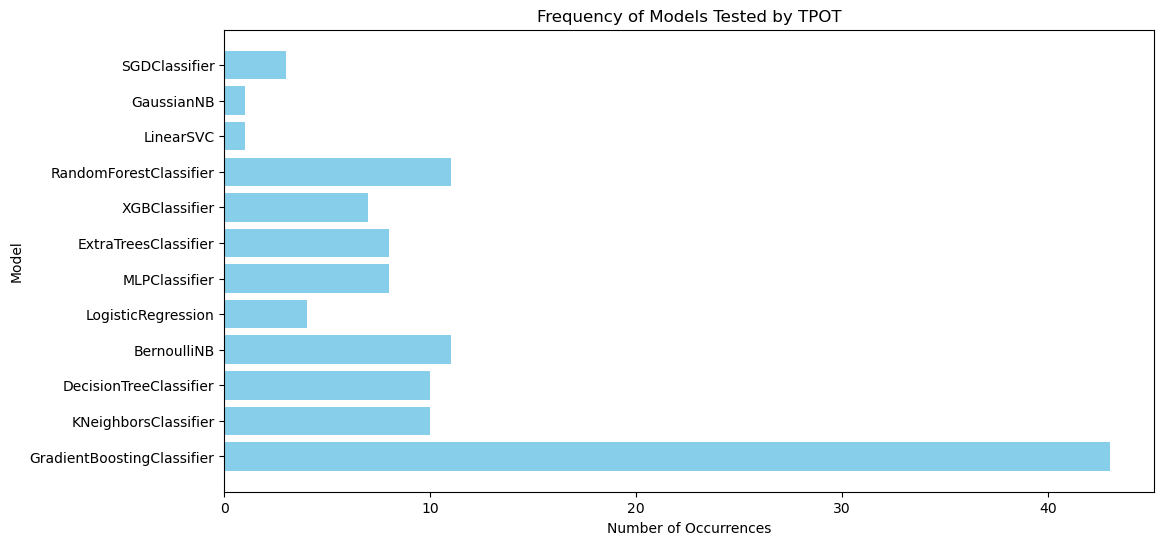

In [32]:
# Count occurrences of each model type
model_counter = Counter()
for pipeline_str in evaluated_pipelines.keys():
    models = re.findall(r'\w+\(.*?\)', pipeline_str)
    for model in models:
        model_name = model.split('(')[0]
        model_counter[model_name] += 1

print("Models and their occurrences:")
for model, count in model_counter.items():
    print(f"{model}: {count}")

# Visualize the count of different models
import matplotlib.pyplot as plt

model_names = list(model_counter.keys())
model_counts = list(model_counter.values())

plt.figure(figsize=(12, 6))
plt.barh(model_names, model_counts, color='skyblue')
plt.xlabel('Number of Occurrences')
plt.ylabel('Model')
plt.title('Frequency of Models Tested by TPOT')
plt.show()